# Image Captioning in Cultural Heritage

In [1]:
from utils import make_paths_relative_to_root,imshow
from data_loader.data_loaders import ArtpediaDataset

from pathlib import Path
import os
import numpy as np
import json
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from transformers import AutoProcessor, AutoModel, AutoModelForCausalLM

make_paths_relative_to_root()

# global configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 2
Image.MAX_IMAGE_PIXELS = None

## Dataset definition

This notebook will use Artpedia Dataset [[1](https://iris.unimore.it/retrieve/handle/11380/1178736/224456/paper.pdf)].
Other art dataset that may be used in future are
- BibleVSA [[6](https://aimagelab.ing.unimore.it/imagelab/pubblicazioni/2018-icpr-bible.pdf)]
- SemArt [[7](https://arxiv.org/pdf/1810.09617v1.pdf)]

The Artpedia Dataset is composed by 2930 paintings, with a variable number of textual descriptions. Each sentence is labelled as *visual* or *contextual*. This work will focus on visual sentences.


- The dataset is constructed by calling `utils.download_images` procedure. This procedure downloads all image from a specified json file, saving them into a local folder. If some URL is not found, it is ignored and excluded from the output dataset. I found (40 in train, 11 in val with error 404)
- Defined a custom `Dataset`, which returns an image and a description of the image, randomly sampled from `visual_sentences` during training, while all available captions are returned during validation and test.
- To create batches more easily, we need to create lists of descriptions of the same length. To do so, we assume that all images have a certain amount of captions, and perform repeated sampling from the visual_sentences.
- Defined a DataLoader which extends the BaseDataLoader class. The image is transformed by resizing to $224 \times 224$ and then processed by HuggingFace AutoProcessor

Average number of visual sentences in train: 3.16500904159132 max: 27 min: 1
Average number of visual sentences in val: 3.0457317073170733 max: 27 min: 1


Text(0.5, 0, '# of visual sentences')

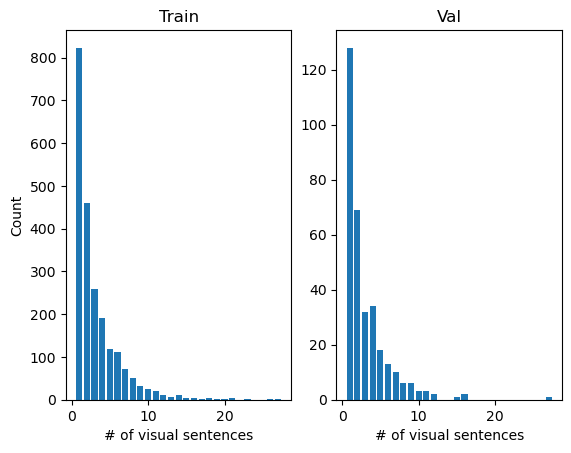

In [2]:
fig, (ax1, ax2) = plt.subplots(1,2)

with open('data/artpedia/train.json') as f:
    j = json.load(f)
    data = list(j.values())

all_labels = []
for r in data:
    all_labels.append(len(r['visual_sentences']))
print(f"Average number of visual sentences in train: {np.mean(all_labels)} max: {np.max(all_labels)} min: {np.min(all_labels)}")

v, cnt = np.unique(all_labels,return_counts=True)

ax1.bar(v,cnt)
ax1.set_title("Train")
ax1.set_ylabel("Count")
ax1.set_xlabel("# of visual sentences")

with open('data/artpedia/val.json') as f:
    j = json.load(f)
    data = list(j.values())

all_labels = []
for r in data:
    all_labels.append(len(r['visual_sentences']))
print(f"Average number of visual sentences in val: {np.mean(all_labels)} max: {np.max(all_labels)} min: {np.min(all_labels)}")

v, cnt = np.unique(all_labels,return_counts=True)

ax2.bar(v,cnt)
ax2.set_title("Val")
ax2.set_xlabel("# of visual sentences")

I chose 10 as the number of visual_sentences

['The throne is similar to the Maestà painted by Cimabue in the Basilica of San Francesco di Assisi (1288–1292).']


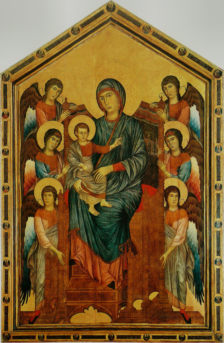

In [3]:
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip()
        ])
test_transform = transforms.Compose([
            transforms.Resize(224)
])

processor = AutoProcessor.from_pretrained("microsoft/git-base")#train_data.dataset.processor
train_ds = ArtpediaDataset('data/artpedia', split='train', transform=train_transform, processor=processor)

# MEAN = np.array([123.675, 116.280, 103.530]) / 255
# STD = np.array([58.395, 57.120, 57.375]) / 255

dataiter = iter(train_ds)
image, label = next(dataiter)

print(label)
display(image)

## Model definition
I used GIT [[2](https://arxiv.org/pdf/2205.14100.pdf)] model. This model is composd by one image encoder and one text decoder, without any other external modules and achieves State Of The Art performance on many benchmarks.

- The image encoder is a Swin-like Vision Transformer pre-trained on massive image-text pairs based on a contrastive task
- The text decoder is a Transformer network that predicts the associated text.


In [4]:
train_dl = DataLoader(train_ds,collate_fn=train_ds._caption_collate,batch_size=BATCH_SIZE)

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(DEVICE)

To check if everything is in place, let's perform inference on a single batch.

input_ids: torch.Size([2, 512])
attention_mask: torch.Size([2, 512])
pixel_values: torch.Size([2, 3, 224, 224])
Original: it is also stylistically earlier to that work, being painted without pseudo - perspective, and having the angels around the virgin simply placed one above the other, rather than being spatially arranged. 
Generated: the painting is hanging

Original: the painting depicts the virgin and child enthroned, surrounded by angels on a gold background. 
Generated: the painting is of a woman



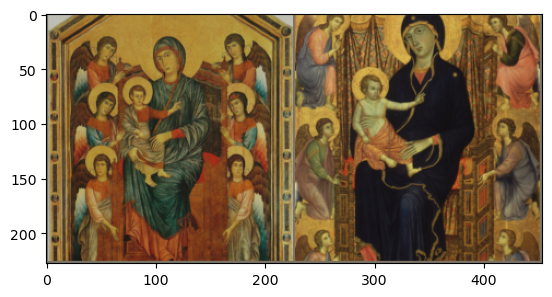

In [5]:
batch = next(iter(train_dl))
for k,v in batch.items():
  print(f"{k}: {v.shape}")

imshow(torchvision.utils.make_grid(batch['pixel_values']))

pixel_values = batch['pixel_values'].to(DEVICE)
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
labels = processor.batch_decode(batch['input_ids'],skip_special_tokens=True)

for l,g in zip(labels,generated_captions):
    print("Original: {} \nGenerated: {}\n".format(l,g))

## Training
Let's try to overfit on a single batch and check if the loss decreases:

In [6]:
import torch
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

for epoch in range(50):
    # for idx, batch in enumerate(tqdm(train_data)):
    input_ids = batch["input_ids"].to(DEVICE)
    pixel_values = batch["pixel_values"].to(DEVICE)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    print("Epoch: {:d} | loss: {:.3f}".format(epoch,loss))
    # print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0 | loss: 12.070
Epoch: 1 | loss: 10.355
Epoch: 2 | loss: 9.895
Epoch: 3 | loss: 9.623
Epoch: 4 | loss: 9.376
Epoch: 5 | loss: 9.133
Epoch: 6 | loss: 8.920
Epoch: 7 | loss: 8.727
Epoch: 8 | loss: 8.555
Epoch: 9 | loss: 8.397
Epoch: 10 | loss: 8.255
Epoch: 11 | loss: 8.130
Epoch: 12 | loss: 8.004
Epoch: 13 | loss: 7.881
Epoch: 14 | loss: 7.769
Epoch: 15 | loss: 7.662
Epoch: 16 | loss: 7.554
Epoch: 17 | loss: 7.452
Epoch: 18 | loss: 7.345
Epoch: 19 | loss: 7.244
Epoch: 20 | loss: 7.147
Epoch: 21 | loss: 7.045
Epoch: 22 | loss: 6.946
Epoch: 23 | loss: 6.846
Epoch: 24 | loss: 6.745
Epoch: 25 | loss: 6.647
Epoch: 26 | loss: 6.546
Epoch: 27 | loss: 6.442
Epoch: 28 | loss: 6.343
Epoch: 29 | loss: 6.241
Epoch: 30 | loss: 6.139
Epoch: 31 | loss: 6.038
Epoch: 32 | loss: 5.936
Epoch: 33 | loss: 5.831
Epoch: 34 | loss: 5.728
Epoch: 35 | loss: 5.624
Epoch: 36 | loss: 5.520
Epoch: 37 | loss: 5.414
Epoch: 38 | loss: 5.310
Epoch: 39 | loss: 5.205
Epoch: 40 | loss: 5.099
Epoch: 41 | loss: 4.991


In [7]:
from model.metric import bleu_score
processor = AutoProcessor.from_pretrained("microsoft/git-base")#train_data.dataset.processor

for k,v in batch.items():
  print(k,v.shape)

pixel_values = batch['pixel_values'].to(DEVICE)
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
labels = processor.batch_decode(batch['input_ids'],skip_special_tokens=True)
for l,g in zip(labels,generated_captions):
    print("Original: {} \nGenerated: {}\n".format(l,g))

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])
Original: it is also stylistically earlier to that work, being painted without pseudo - perspective, and having the angels around the virgin simply placed one above the other, rather than being spatially arranged. 
Generated: it is also stylistically earlier to that work, being painted without pseudo - perspective, and having the angels around the virgin simply placed one above the other, rather than being the other, rather

Original: the painting depicts the virgin and child enthroned, surrounded by angels on a gold background. 
Generated: it is also stylistically earlier to that work, being painted without pseudo - perspective, and having the angels around the virgin simply placed one above the other, rather than being spatially arranged.



Our model successfully overfits the batch. Now we evaluate the performance of the untrained model over the whole valid set

## Evaluation

In [12]:
valid_ds = ArtpediaDataset('data/artpedia', split='val', transform=test_transform, processor=processor)
valid_dl = DataLoader(valid_ds,collate_fn=valid_ds._caption_collate,batch_size=BATCH_SIZE)
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(DEVICE)
model.eval()
labels, predictions = [], []
for batch in tqdm(valid_dl):
    batch, all_captions = batch
    batch = {k:v.to(DEVICE) for k,v in batch.items()}
    decoded_labels = processor.batch_decode(batch['input_ids'],skip_special_tokens=True)
    labels += all_captions
    generated_ids = model.generate(pixel_values=batch['pixel_values'], max_length=50)
    generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
    predictions += generated_captions

100%|██████████| 164/164 [02:25<00:00,  1.13it/s]


### BLEU
BLEU [[3](https://aclanthology.org/P02-1040.pdf)] is a metric typically used in Machine Translation to evaluate the quality of generated text, as the correspondence between the generated output and a human generated text.

Scores are calculated for single sentences, by comparing them with a set of good translations. Those scores are averaged over the whole corpus to reach an estimate of the generated text.

In [13]:
from torchmetrics import BLEUScore
bleus = {}
for n in range(1,5):
    bleu = BLEUScore(n)
    bleus[n] = bleu(predictions,labels)
for k,v in bleus.items():
    print(f"BLEU {k}: {v:.2f}")


BLEU 1: 0.05
BLEU 2: 0.02
BLEU 3: 0.01
BLEU 4: 0.01


### BERT

In [14]:
from torchmetrics.text import BERTScore
bert = BERTScore()
# print([' '.join(l) for l in labels])
b_score = bert(predictions,[' '.join(l) for l in labels])
print(f"BERT score: {b_score}")

C:\Users\Dario\mambaforge\envs\nlp\lib\site-packages\torchmetrics\text\bert.py:179: UserWarning: The argument `model_name_or_path` was not specified while it is required when the default `transformers` model is used. It will use the default recommended model - 'roberta-large'.
  warn(


KeyboardInterrupt: 

### Rouge
ROUGE [[5](https://aclanthology.org/W04-1013.pdf)] metrics are used for evaluating automatic summarization and machine translation. The metrics compare a summary or translation against a reference or a set of references.

- ROUGE-N: Overlap of n-grams between the system and reference summaries
- ROUGE-L: Longest Common Subsequence (LCS) between statistics. LCS takes into account sentence-level structure similarity and identifies longest co-occurring in sequence n-grams automatically

In [15]:
from torchmetrics.text import ROUGEScore
from pprint import pprint
rouge = ROUGEScore()
pprint(rouge(predictions,labels))
pprint(rouge(predictions,[' '.join(l) for l in labels]))

{'rouge1_fmeasure': tensor(0.1753),
 'rouge1_precision': tensor(0.4038),
 'rouge1_recall': tensor(0.1197),
 'rouge2_fmeasure': tensor(0.0224),
 'rouge2_precision': tensor(0.0569),
 'rouge2_recall': tensor(0.0149),
 'rougeL_fmeasure': tensor(0.1485),
 'rougeL_precision': tensor(0.3444),
 'rougeL_recall': tensor(0.1013),
 'rougeLsum_fmeasure': tensor(0.1485),
 'rougeLsum_precision': tensor(0.3444),
 'rougeLsum_recall': tensor(0.1013)}
{'rouge1_fmeasure': tensor(0.0263),
 'rouge1_precision': tensor(0.4992),
 'rouge1_recall': tensor(0.0136),
 'rouge2_fmeasure': tensor(0.0037),
 'rouge2_precision': tensor(0.0833),
 'rouge2_recall': tensor(0.0019),
 'rougeL_fmeasure': tensor(0.0257),
 'rougeL_precision': tensor(0.4897),
 'rougeL_recall': tensor(0.0133),
 'rougeLsum_fmeasure': tensor(0.0245),
 'rougeLsum_precision': tensor(0.4665),
 'rougeLsum_recall': tensor(0.0127)}


## References
[[1](https://iris.unimore.it/retrieve/handle/11380/1178736/224456/paper.pdf)] Stefanini, Matteo, et al. "Artpedia: A new visual-semantic dataset with visual and contextual sentences in the artistic domain." Image Analysis and Processing–ICIAP 2019: 20th International Conference, Trento, Italy, September 9–13, 2019, Proceedings, Part II 20. Springer International Publishing, 2019.
[[2](https://arxiv.org/pdf/2205.14100)] Wang, Jianfeng, et al. "Git: A generative image-to-text transformer for vision and language." arXiv preprint arXiv:2205.14100 (2022).
[[3](https://aclanthology.org/P02-1040.pdf)] Papineni, Kishore, et al. "Bleu: a method for automatic evaluation of machine translation." Proceedings of the 40th annual meeting of the Association for Computational Linguistics. 2002.
[[4](https://arxiv.org/pdf/1904.09675)] Zhang, Tianyi, et al. "Bertscore: Evaluating text generation with bert." arXiv preprint arXiv:1904.09675 (2019).
[[5](https://aclanthology.org/W04-1013.pdf)] Lin, Chin-Yew. "Rouge: A package for automatic evaluation of summaries." Text summarization branches out. 2004.
[[6](https://aimagelab.ing.unimore.it/imagelab/pubblicazioni/2018-icpr-bible.pdf)] Baraldi, Lorenzo, et al. "Aligning text and document illustrations: towards visually explainable digital humanities." 2018 24th International Conference on Pattern Recognition (ICPR). IEEE, 2018.
[[7](https://arxiv.org/pdf/1810.09617v1.pdf)] Garcia, Noa, and George Vogiatzis. "How to read paintings: semantic art understanding with multi-modal retrieval." Proceedings of the European Conference on Computer Vision (ECCV) Workshops. 2018.